In [3]:
%pip install scikits-bootstrap --user
%pip install pymicro --user
%pip install vtk --user

^C
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from scipy import *
from matplotlib.pyplot import *

import glob,os,sys,csv
import pandas as pd 
from random import shuffle, sample
from numpy.linalg import norm
import statsmodels.nonparametric.smoothers_lowess as loess
from scipy.io import *
import seaborn as sns
os.chdir('S01')			# Change this to change the subject
from circ_stats import * 								# File needs to be in the wd
from time import time, sleep


FileNotFoundError: [Errno 2] No such file or directory: 'S01'

In [2]:
pip uninstall psychopy

Found existing installation: PsychoPy 2021.2.3
Uninstalling PsychoPy-2021.2.3:
  Would remove:
    /opt/anaconda3/envs/wm_exp/bin/psychopy
    /opt/anaconda3/envs/wm_exp/lib/python3.8/site-packages/PsychoPy-2021.2.3.dist-info/*
    /opt/anaconda3/envs/wm_exp/lib/python3.8/site-packages/building/*
    /opt/anaconda3/envs/wm_exp/lib/python3.8/site-packages/psychopy/*
Proceed (Y/n)? ^C
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.


In [3]:
#%% FUNCTIONS
def len2(x):
	if type(x) is not type([]):
		if type(x) is not type(array([])):
			return -1
	return len(x)

def circdist(angles1,angles2):
    if len2(angles2) < 0:
        if len2(angles1) > 0:
            angles2 = [angles2]*len(angles1)
        else:
            angles2 = [angles2]
            angles1 = [angles1]
    if len2(angles1) < 0:
        angles1 = [angles1]*len(angles2)
        
    return np.angle(exp(1j*angles1)/exp(1j*angles2))
        
    #return amap(lambda a1,a2: phase2(exp(1j*a1)/exp(1j*a2)), angles1,angles2)

def circ_mean(x):
	return circmean(x,low=-pi,high=pi)

def rem_sys_err(report,target,w):
    n=[]
    for x in arange(-pi,pi,w):
        d=circdist(target,x)
        idx = (d >= x) & (d<x+w)
        report[idx] = circdist(report[idx],circmean(circdist(report[idx],target[idx]),low=-pi,high=pi))
        n.append(sum(idx))
        
    return report,n

def rem_sys_err2(report,target,frac=.25):
    #''' Removes from the response the systematic error of the subject.'''
    fit_resp = loess.lowess(report, target, frac = frac, return_sorted = False)
    fit_error = circdist(fit_resp, target)
    clean_res = circdist(report, fit_error) # Clean response ?
    return clean_res

def compute_serial(report,target,pre_target,xxx,flip=None,ref_report=False):
	report = rem_sys_err2(array(report),array(target))
	err = circdist(report,target)
	d = circdist(pre_target,target) #Previous cue - current cue
	if ref_report:
		d=circdist(report[:-1],target[1:])
	
	# remove outliers
	idx_clean=(abs(err)<3*std((err))) & (abs(err)<1)
	#idx_clean = idx_clean & (report[1:] !=0)
	
	err=err[idx_clean]
	d=d[idx_clean]
	m_err=[]
	std_err=[]
	count=[]
	cis=[]
	if flip:
		err = sign(d)*err
		d=abs(d)
	points_idx=[]
	for t in xxx:
		idx=(d>=t)&(d<=t+w2)
		m_err.append(circ_mean(err[idx]))
		std_err.append(circstd(err[idx])/sqrt(sum(idx)))
		count.append(sum(idx))
		points_idx.append(idx)
	return array(err),d,array(m_err),array(std_err),count,points_idx


In [4]:
#%% IMPORT DATA
df = pd.read_csv('behav/behav.csv')
try:
	df['TMS_trial'] = df['flash'] # New version won't fail
except:
	df['flash'] = df['TMS_trial'] 	# Old version needs to have this.
	df['recorded']=df['trial']
	df['preT'] = roll(df['T_Angle'],1)
	df['preT'][0] = nan


/home/albert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
from pymicro.view.vol_utils import compute_affine_transform
# compute the affine transform from the point set

radius = np.sqrt(np.mean(df.choice_x**2+df.choice_y**2))
ref_points = np.array([[radius*np.cos(np.deg2rad(df.T_Angle[i])), radius*np.sin(np.deg2rad(df.T_Angle[i]))] for i in range(len(df))])
tsr_points = np.array([[df.choice_x[j], df.choice_y[j]] for j in range(len(df))])
translation, transformation = compute_affine_transform(ref_points, tsr_points)
ref_centroid = np.mean(ref_points, axis=0)
tsr_centroid = np.mean(tsr_points, axis=0)
new_points = np.empty_like(ref_points)
for j in range(len(df)):
    new_points[j] = ref_centroid + np.dot(transformation, tsr_points[j] - tsr_centroid)

df['choiceAngle_corr'] = np.rad2deg(np.arctan2(new_points[:,1], new_points[:,0]))

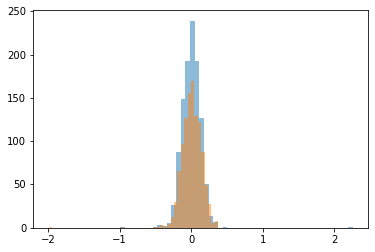

In [6]:
hist(circdist(np.deg2rad(df.choiceAngle_corr.values), np.deg2rad(df.T_Angle.values)),50, alpha=0.5);
hist(circdist(np.deg2rad(df.choiceAngle.values), np.deg2rad(df.T_Angle.values)),50, alpha=.5);

In [7]:
#%% PARAMETERS
w1=pi/50
w2=pi/2
xxx=arange(-pi,pi-w2+w1,w1)
flip = False


In [8]:
#sns.set_context('poster')
T = radians(array(df['T_Angle']))
R = radians(array(df['choiceAngle_corr']))
P = radians(array(df['preT']))
TMS = array(df['TMS_trial'])


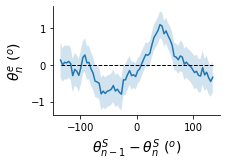

In [15]:
figure(figsize=[3,2])
xxx=arange(-pi,pi-w2+w1,w1)
flip = False
#%%
#figure(figsize=(10,8))
#err,d,m_err,std_err,count,points_idx = compute_serial(R,T,xxx,flip,False)
err,d,m_err,std_err,count,points_idx = compute_serial(R,T,P,xxx,flip,False)

m_err=rad2deg(m_err)
std_err=rad2deg(std_err)

plot(rad2deg(xxx+w2/2),m_err,linewidth=1.5)
fill_between(rad2deg(xxx+w2/2), m_err + std_err, m_err - std_err,alpha=.2)
#errorbar(xxx+w2/2,m_err,std_err)
plot(rad2deg(xxx+w2/2),zeros(len(xxx)),"k--",linewidth=1)

xlabel(r'$\theta_{n-1}^S - \theta_n^S$ ($^o$)', fontsize=14); ylabel(r'$\theta_n^e$ ($^o$)', fontsize=14);
sns.despine()
savefig('serialbias_S1.svg')

adict={}
adict['m_err']=m_err
adict['std_err']=std_err
adict['xxx']=xxx
adict['w2']=w2
from scipy.io import savemat
savemat('../serialbias_S1.mat',adict)

In [10]:
from scipy.io import loadmat
s01 = loadmat('../decoder_S01.mat',squeeze_me=True)

In [58]:
mdn=np.median(abs(s01['err_loo_fx']))
mid=0
lpct,hpct = np.percentile(abs(s01['err_loo_fx']),[50-mid,50+mid])
lowtrials = abs(s01['err_loo_fx'])>hpct
hightrials = abs(s01['err_loo_fx'])<=lpct

In [59]:
lpct

1.487063780389146

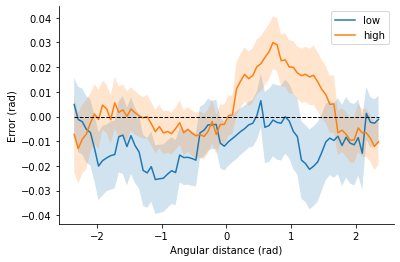

In [60]:
xxx=arange(-pi,pi-w2+w1,w1)
flip = False

R0=R[1:]
T0=T[1:]
P0=P[1:]

err_l,d,m_err_l,std_err_l,count,points_idx = compute_serial(R0[lowtrials],T0[lowtrials],P0[lowtrials],xxx,flip,False)
err_h,d,m_err_h,std_err_h,count,points_idx = compute_serial(R0[hightrials],T0[hightrials],P0[hightrials],xxx,flip,False)

plot(xxx+w2/2,m_err_l,linewidth=1.5,label='low')
fill_between(xxx+w2/2, m_err_l + std_err_l, m_err_l - std_err_l,alpha=.2)
plot(xxx+w2/2,m_err_h,linewidth=1.5,label='high')
fill_between(xxx+w2/2, m_err_h + std_err_h, m_err_h - std_err_h,alpha=.2)
#errorbar(xxx+w2/2,m_err,std_err)
plot(xxx+w2/2,zeros(len(xxx)),"k--",linewidth=1)
legend()

xlabel('Angular distance (rad)'); ylabel('Error (rad)');
sns.despine()
#savefig('serialbias.svg')


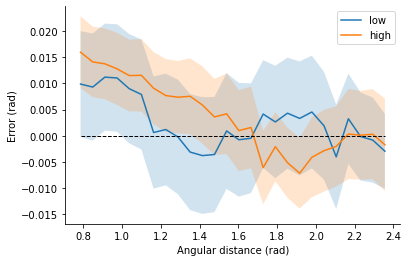

In [61]:
flip=True
xxx=arange(0,pi-w2+w1,w1)

R0=R[1:]
T0=T[1:]
P0=P[1:]

err_l,d,m_err_l,std_err_l,count,points_idx = compute_serial(R0[lowtrials],T0[lowtrials],P0[lowtrials],xxx,flip,False)
err_h,d,m_err_h,std_err_h,count,points_idx = compute_serial(R0[hightrials],T0[hightrials],P0[hightrials],xxx,flip,False)

plot(xxx+w2/2,m_err_l,linewidth=1.5,label='low')
fill_between(xxx+w2/2, m_err_l + std_err_l, m_err_l - std_err_l,alpha=.2)
plot(xxx+w2/2,m_err_h,linewidth=1.5,label='high')
fill_between(xxx+w2/2, m_err_h + std_err_h, m_err_h - std_err_h,alpha=.2)
#errorbar(xxx+w2/2,m_err,std_err)
plot(xxx+w2/2,zeros(len(xxx)),"k--",linewidth=1)
legend()

xlabel('Angular distance (rad)'); ylabel('Error (rad)');
sns.despine()
#savefig('serialbias.svg')



In [62]:
adict['m_err_l']=m_err_l
adict['std_err_l']=std_err_l
adict['m_err_h']=m_err_h
adict['std_err_h']=std_err_h
adict['xxx_l']=xxx
adict['w2_l']=w2
from scipy.io import savemat
savemat('../serialbias_S1.mat',adict)

NameError: name 'lpct' is not defined